In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
import pack_ga
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


vast
vast
stop final relax at some point


In [2]:
importlib.reload(pack_ga)
fastMode = False
runner = pack_ga.GA()
runner.N_trees_to_do = np.array([40])
if fastMode:
    runner.initializer.jiggler.duration_compact /= 10
    runner.initializer.jiggler.plot_interval = None
    runner.initializer.jiggler.n_rounds = 1
    runner.relaxers = runner.relaxers[:1]
    runner.relaxers[0].n_iterations= 10
    runner.n_generations = 100
    runner.population_size = 10
runner.run()
plt.plot(runner.best_cost_per_generation)

stop final relax at some point
Generation 0, Trees 40, Best cost: 0.15161400, Est: 0.37903500, h: 3.872320
Generation 1, Trees 40, Best cost: 0.15159447, Est: 0.37898619, h: 3.872505
Generation 2, Trees 40, Best cost: 0.15160851, Est: 0.37902129, h: 3.872290
Generation 3, Trees 40, Best cost: 0.15159459, Est: 0.37898648, h: 3.872473
Generation 4, Trees 40, Best cost: 0.15162632, Est: 0.37906580, h: 3.872520
Generation 5, Trees 40, Best cost: 0.15162441, Est: 0.37906103, h: 3.872539
Generation 6, Trees 40, Best cost: 0.15161406, Est: 0.37903514, h: 3.872525
Generation 7, Trees 40, Best cost: 0.15153244, Est: 0.37883110, h: 3.871783
Generation 8, Trees 40, Best cost: 0.15152289, Est: 0.37880723, h: 3.871633
Generation 9, Trees 40, Best cost: 0.15138517, Est: 0.37846293, h: 3.869822
Generation 10, Trees 40, Best cost: 0.15138228, Est: 0.37845571, h: 3.869721
Generation 11, Trees 40, Best cost: 0.15140942, Est: 0.37852354, h: 3.869563
Generation 12, Trees 40, Best cost: 0.15126613, Est: 0.

KeyboardInterrupt: 

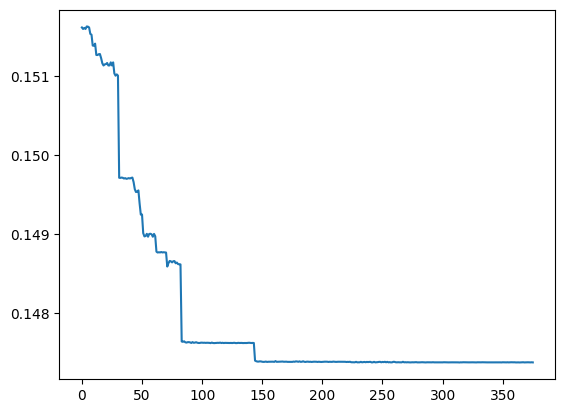

In [5]:
plt.plot(runner.best_cost_per_generation[:376])